# Libraries

In [1]:
import numpy as np
import numpy.random as rnd
import numpy.linalg
import matplotlib.pyplot as plt
from numpy import linalg as LA
from numpy.random import normal
import scipy
from scipy.spatial.transform import Rotation as R

In [58]:


class Configuration:
    #"""generate a configuration of spins"""
    
    def __init__(self, a,theta,Nx,Ny, J,T):
        #'we create a kagome lattice from parameter a and theta with Nx*Ny*3 spins , '
        self.a,self.theta,self.Nx,self.Ny,self.J,self.T=a,theta,Nx,Ny,J,T
        self.N=Nx*Ny

        # a_1 and a_2 are the lattice translation generating vectors 
        a_1=a*np.array([1,0])
        a_2=a*np.array([-1*np.cos(theta),np.sin(theta)])
        
        # we construct the unit cell
        unit_cell=np.array([[0,0],0.5*a_2,0.5*a_1])
        
        # we construct the grid points from the translations of the lattice
        self.x_l,self.y_l=np.meshgrid(range(Nx),range(Ny))
        A_1=np.tensordot(self.y_l,[a_1,a_1,a_1],axes=0)
        A_2=np.tensordot(self.x_l,[a_2,a_2,a_2],axes=0)

        # the lattice points coordinates are created from adding a unit cell at each grid point
        self.lattice=np.tensordot(np.ones((Nx,Ny)),unit_cell,axes=0)+A_1+A_2

        # we create a dim object containing the dimensions of the lattice 
        dim=self.lattice.shape

        # then we create a random spin configuration  self.config as a unit 3d vector on each grid point
        #np.random.seed(50) #seed control for test
        
        config=2*np.random.rand(dim[0],dim[1],dim[2],3)-1*np.ones((dim[0],dim[1],dim[2],3))
        Norm=np.power(LA.norm(config,axis=0),-1)
        self.config=Norm*config
        #print(self.config)



    def get_energy(self,sublattice):
        """this part implements the sommation over spins in a triangle(sublattice)"""
        
        #S2=(S_1+S_2+S_3)^2
        S2=(sublattice[0,:]+sublattice[1,:]+sublattice[2,:])**2
        #(J/2) * norm((S_1+S_2+S_3)^2)
        E=(self.J/2)*np.sum(S2)
        return E

    def total_energy(self):
        """ this part implements the summation of energy over the whole lattice"""

        E=0
        for i in range(self.Nx):
            for j in range(self.Ny):
                # we have for each triangle up self.config[i,j,:,:] 
                # the triangle down formed from the sites 
                Triangle_down=[[i,j,0],[i,j-1,1],[i-1,j,2]]

                # we use the get eneergy function on each triangles for all the lattice
                E=E+self.get_energy(self.config[i,j,:,:])+self.get_energy(self.config[Triangle_down])
        
        return E


    def delta_energy(self,x_i,y_i,s_i):
        ''' this function is used to compute the energy difference for a flip '''

        # we get the new spin configuration
        newconf=self.newconf
        # Just as before we compute the coordinates of the two sublattices (triangles) affected by this modification
        kernel=[[[x_i,y_i-1,1],[x_i-1,y_i,2]],[[x_i-1,y_i+1,2],[x_i,y_i+1,0]],[[x_i+1,y_i-1,1],[x_i+1,y_i,0]]]
        Triangle_up=[[x_i,y_i,0],[x_i,y_i,1],[x_i,y_i,2]]
        Triangle_down=np.mod([[x_i,y_i,s_i]]+kernel[s_i],[self.Nx,self.Ny,3])

        #the energy differnece between the new config (self.newconf) and the old one (self.conf) is computed 
        Delta_E= self.get_energy(newconf[Triangle_up])+self.get_energy(newconf[Triangle_down])-self.get_energy(self.config[Triangle_up])-self.get_energy(self.config[Triangle_down])


        return Delta_E




    def Monte_Carlo(self,Nf,overrelaxation=False,ecart_type=0.01):
        '''In this part we implement the Nf monte carlo steps
        here with the metropolis move'''


        # this code will select a number Nf of random 3d rotations 
        #all with the same probability over the sphere
        beta=1/self.T
        q = normal(size=(Nf,4))
        q /= np.linalg.norm(q) 
        r = R.from_quat(q)

        # if we want to use the overrelaxation 
        #this code will select a number Nf of random 3d rotations 
        #with a gaussian distribution around identity
        if overrelaxation==True:
            q =normal(scale=[1,ecart_type,ecart_type,ecart_type],size=(4))
            q = normal(size=(Nf,4))
            q /= np.linalg.norm(q) 
            r = R.from_quat(q)

        # we select the number Nf of sites that could be flipped
        flips=np.random.randint([0,0,0],[self.Nx-1,self.Ny-1,2],size=(Nf,3))

        # we initialize a copy of the current spin configuration named self.newconf
        self.newconf=self.config
        
        #this flag is an integer to count the number of flips that are validated 
        # to keep track of the rejection  rate
        flag=0

        for num,pick in enumerate(flips):
            # we  we rotate a spin of the new configuration 

            self.newconf[pick[0],pick[1],pick[2],:]= r[num].apply( self.config[pick[0],pick[1],pick[2],:] ) 

            # we renormalise this spin after rotation because matrix 
            # multiplication errors can denormalise a little bit after a rotation our unit vectors
            Norm=np.power(LA.norm(self.newconf,axis=0),1)
            self.newconf/=Norm

            # energy difference calculations
            delta= self.delta_energy(pick[0],pick[1],pick[2])

            #metropolis move
            if rnd.random() < np.exp(-beta*delta):
                self.config=self.newconf
                flag+=1
            
        #print('Acceptance rate=',flag/Nf)


    def display_config(self):

        ax = plt.figure().add_subplot(projection='3d')

        position=np.reshape(self.lattice,(3*self.Nx*self.Ny,2),order='C')
        arrows=np.reshape(self.config,(3*self.Nx*self.Ny,3),order='C')

        # Make the grid
        x, y, z = position[:,0],position[:,1],np.zeros((3*self.Nx*self.Ny))

        # Make the direction data for the arrows
        u = arrows[:,0]
        v = arrows[:,1]
        w = arrows[:,2]
        
        ax.quiver(x,y,z, u, v, w, length=0.1, normalize=False,pivot='tail')
        ax.view_init(elev=0, azim=0, roll=0)
        plt.show()


        ax = plt.figure().add_subplot(projection='3d')

        ax.quiver(x,y,z, u, v, w, length=0.1, normalize=False,pivot='tail')
        ax.view_init(elev=0, azim=90, roll=0)


        plt.show()

        ax = plt.figure().add_subplot(projection='3d')

        ax.quiver(x,y,z, u, v, w, length=0.1, normalize=False,pivot='tail')
        
        ax.view_init(elev=90, azim=90, roll=0)


        plt.show()


    def spin_realign(self):

        ax = plt.figure().add_subplot(projection='3d')

        position=np.reshape(self.lattice,(3*self.Nx*self.Ny,2),order='C')
        arrows=np.reshape(self.config,(3*self.Nx*self.Ny,3),order='C')



        Avg=np.mean(arrows,axis=0)
        print(Avg)
        Avg/=np.linalg.norm(Avg)
        r = R.from_quat([0,1,1,0])
        arrows=r.apply(arrows,inverse=False)
        print(np.mean(arrows,axis=0))



        # Make the grid
        x, y, z = position[:,0],position[:,1],np.zeros((3*self.Nx*self.Ny))

        # Make the direction data for the arrows
        u = arrows[:,0]
        v = arrows[:,1]
        w = arrows[:,2]
        
        ax.quiver(x,y,z, u, v, w, length=0.1, normalize=False,pivot='tail')
        ax.view_init(elev=0, azim=0, roll=0)
        plt.show()


    def verify_norm(self):
        """ we have sometimes a problem with the  spin vectors not 
        being normalised after too many rotations due to errors so we normalise them after each 
        flip and we verify their maximum norms"""
        print('norm=',LA.norm(self.config,axis=0).max())




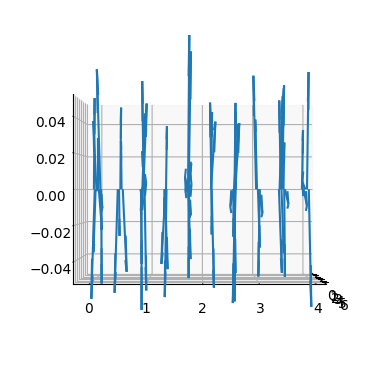

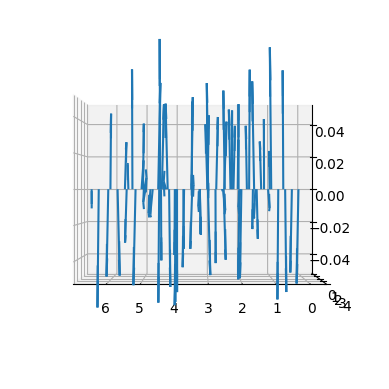

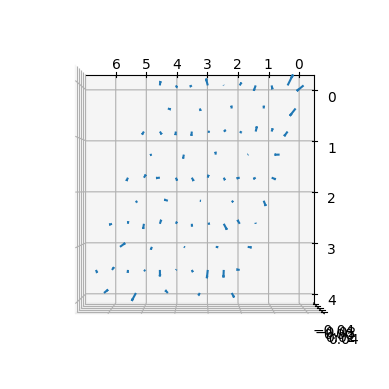

[0.04578095 0.11378707 0.00144861]
[-0.04578095  0.00144861  0.11378707]


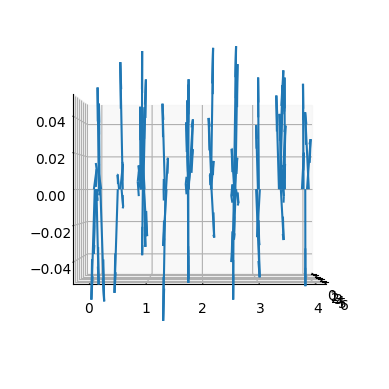

In [59]:
J=1
T=100
Nx=5
Ny=5
theta=2*np.pi/3
a=1
A=Configuration(1,theta,Nx,Ny,J,T)
A.display_config()
A.spin_realign()
A.Monte_Carlo(8000,overrelaxation=False)
#A.display_config()

# Infos about the simulation class

- we generate the kagome lattice site coordinate from a lieb lattice that we sheared  with an angle of 2*pi/3 see
https://doi.org/10.48550/arXiv.2506.15023

- for spin rotations we need to pick a random 3d rotations we thus use a normal distribution of quaternions see method
https://imois.in/posts/random-vectors-and-rotations-in-3d/
https://doi.org/10.1016/B978-0-08-050755-2.50036-1

The 3 first indices of the matrix are for each spins  the first Nx triangles horizontally Ny triangles
vertically and 3 sites in the triangle the left one is 0 the top one is 1 an the left one is 2



- I need to rewrite a fast energy calculation to implement the different monte carlo algorythm 
- we also need a fast way to display the lattice

19.56589290443682
18.48589513343991
19.272579497246586


ValueError: not enough values to unpack (expected 3, got 2)

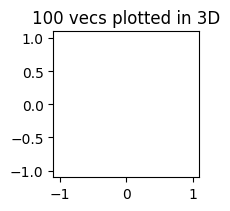

In [8]:
J=1
T=1
Nx=10
Ny=10
theta=2*np.pi/3
a=1
A=Configuration(1,theta,Nx,Ny,J,T)

B=Configuration(1,theta,Nx,Ny,J,T)
C=Configuration(1,theta,Nx,Ny,J,T)
N=Nx*Ny*3
E_0=(J/2)*Nx*Ny*3*1
print((A.total_energy()-E_0)/N)
print((B.total_energy()-E_0)/N)
print((C.total_energy()-E_0)/N)
TestA=[]
TestB=[]
TestC=[]
for u in range(100):
    A.Monte_Carlo(800,overrelaxation=False)
    #A.Overrelaxation(200)
    #A.verify_norm()
    TestA.append((A.total_energy()-E_0)/N)

A.display_config()
for u in range(100):
    #A.Monte_Carlo(200)
    B.Monte_Carlo(800,overrelaxation=True, ecart_type=10**-10)
    #B.verify_norm()
    TestB.append((B.total_energy()-E_0)/N)


for u in range(100):
    #A.Monte_Carlo(200)
    C.Monte_Carlo(800,overrelaxation=True, ecart_type=10**-10)
    if u%25==0:
        C.Monte_Carlo(2000,overrelaxation=False, ecart_type=0.01)
    #C.verify_norm()
    TestC.append((C.total_energy()-E_0)/N)

import matplotlib.pyplot as plt

plt.plot(range(len(TestA)),TestA,label='monte')
plt.plot(range(len(TestB)),TestB,label='over')
plt.plot(range(len(TestC)),TestC,label='overC')

plt.legend()
plt.show()


#plt.plot(range(len(TestB)),TestB,label='over')
#plt.legend()
#plt.show()

In [42]:
import numpy as np
import numpy.random as rnd
import numpy.linalg
import matplotlib.pyplot as plt
from numpy import linalg as LA
from numpy.random import normal
import scipy
from scipy.spatial.transform import Rotation as R

number of lattice points= 75
()
50.237633980998865


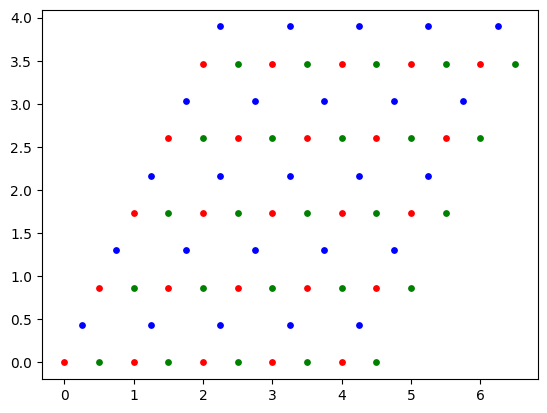

In [43]:
a=1
theta=2*np.pi/3
Nx=5
Ny=5
N=Nx*Ny
print('number of lattice points=',3*N)


a_1=a*np.array([1,0])
a_2=a*np.array([-1*np.cos(theta),np.sin(theta)])

unit_cell=np.array([[0,0],0.5*a_2,0.5*a_1])
x_l,y_l=np.meshgrid(range(Nx),range(Ny))
lattice=np.tensordot(np.ones((Nx,Ny)),unit_cell,axes=0)+np.tensordot(y_l,[a_1,a_1,a_1],axes=0)+np.tensordot(x_l,[a_2,a_2,a_2],axes=0)


dim=lattice.shape
config=2*np.random.rand(dim[0],dim[1],dim[2],3)-1*np.ones((dim[0],dim[1],dim[2],3))


Norm=np.power(LA.norm(config,axis=0),-1)
config=Norm*config



A=config[:,:,0,:]+config[:,:,1,:]+config[:,:,2,:]
B=A[:,:,0]*A[:,:,0]+A[:,:,1]*A[:,:,1]+A[:,:,2]*A[:,:,2]
C=np.sum(B)
print(C.shape)
print(C)

for i, color in enumerate(['red','blue', 'green']):
    plt.scatter(lattice[:,:,i,0],lattice[:,:,i,1], c=color, label=' ',s=15)

plt.show()

q = normal(size=(10,4))
q /= np.linalg.norm(q) 
r = R.from_quat(q)
v = r.apply(np.array([0,1,0]))  



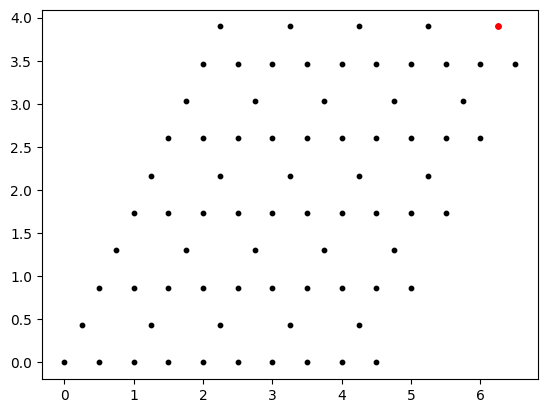

In [44]:
x_1,y_1,s_1=4,4,1

for i, color in enumerate(['black','black', 'black']):

    plt.scatter(lattice[:,:,i,0],lattice[:,:,i,1], c=color, label=' ',s=10)

plt.scatter(lattice[x_1,y_1,s_1,0],lattice[x_1,y_1,s_1,1], c='red', label=' ',s=15)

plt.show()


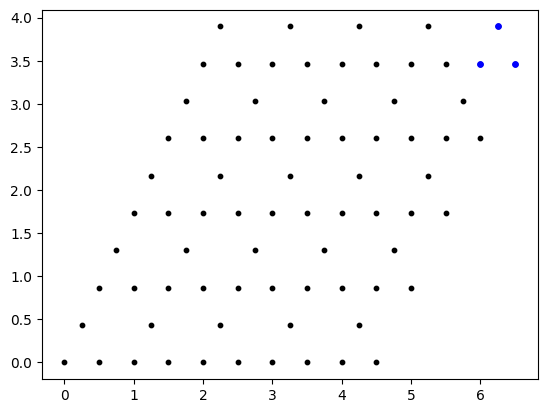

In [45]:


for i, color in enumerate(['black','black', 'black']):

    plt.scatter(lattice[:,:,i,0],lattice[:,:,i,1], c=color, label=' ',s=10)


plt.scatter(lattice[x_1,y_1,0,0],lattice[x_1,y_1,0,1], c='blue', label=' ',s=15)
plt.scatter(lattice[x_1,y_1,1,0],lattice[x_1,y_1,1,1], c='blue', label=' ',s=15)
plt.scatter(lattice[x_1,y_1,2,0],lattice[x_1,y_1,2,1], c='blue', label=' ',s=15)
plt.show()

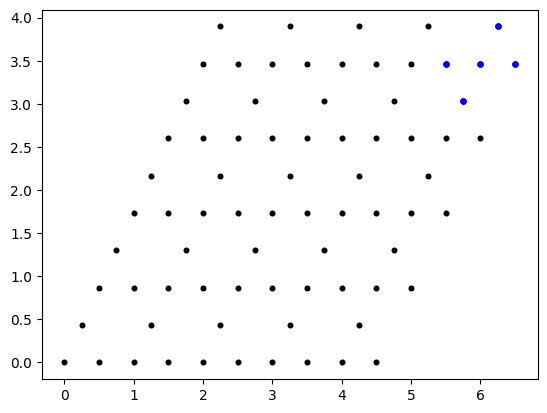

In [46]:
def Nearest_neighbor(x_i,y_i,s_i,Nx=Nx,Ny=Ny):

   
    kernel=[[[x_i,y_i-1,1],[x_i-1,y_i,2]],[[x_i-1,y_i+1,2],[x_i,y_i+1,0]],[[x_i+1,y_i-1,1],[x_i+1,y_i,0]]]
    neighbors=[[x_i,y_i,(s_i+1)%3],[x_i,y_i,(s_i+2)%3]]
    neighbors=neighbors+kernel[s_i]
    return np.mod(neighbors,[Nx,Ny,3])


x_1,y_1,s_1=4,4,0
test=Nearest_neighbor(x_1,y_1,s_1)



for i, color in enumerate(['black','black', 'black']):

    plt.scatter(lattice[:,:,i,0],lattice[:,:,i,1], c=color, label=' ',s=11)

plt.scatter(lattice[x_1,y_1,s_1,0],lattice[x_1,y_1,s_1,1], c='blue', label=' ',s=15)

for z in test:
    plt.scatter(lattice[z[0],z[1],z[2],0],lattice[z[0],z[1],z[2],1], c='blue', label=' ',s=15)

plt.show()




# Method to get the conjugate lattice

In [47]:
def Antilattice(lattice):

    P0=lattice[:,:,1,:]
    P1=np.roll(lattice[:,:,2,:],(1,-1),(0,1))
    P2=np.roll(lattice[:,:,0,:],-1,1)

    Anti_lattice= np.concatenate((P0,P1,P2),axis=2).reshape((Nx,Ny,3,2),order='C')
    lattice=np.roll(Anti_lattice,(0,0,1),(0,1,2))

    return lattice


number of lattice points= 75


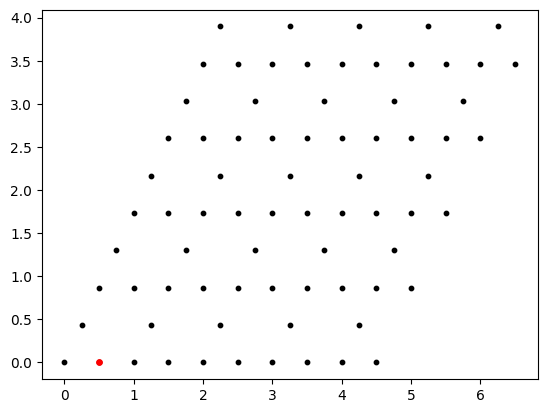

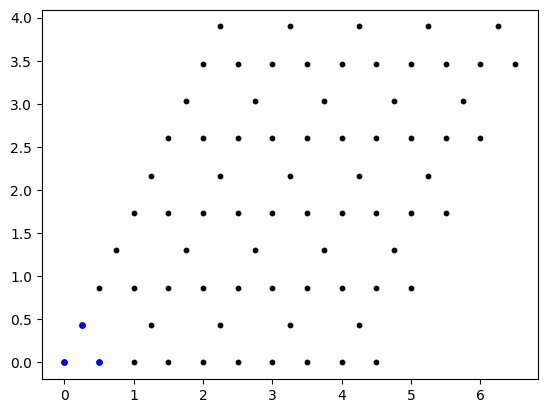

(5, 5, 3, 2)


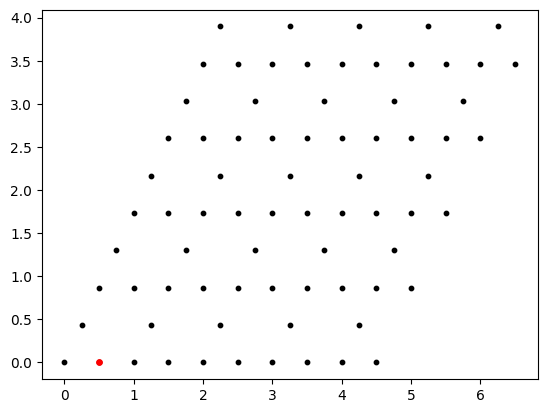

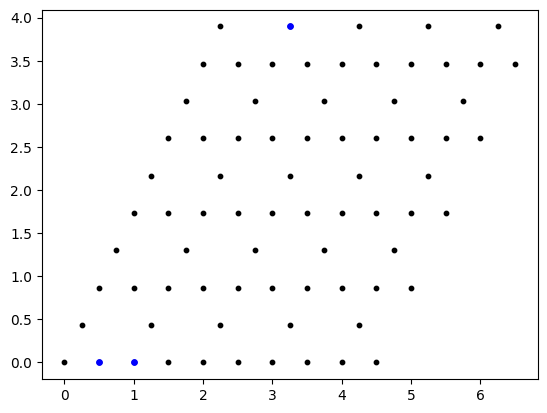

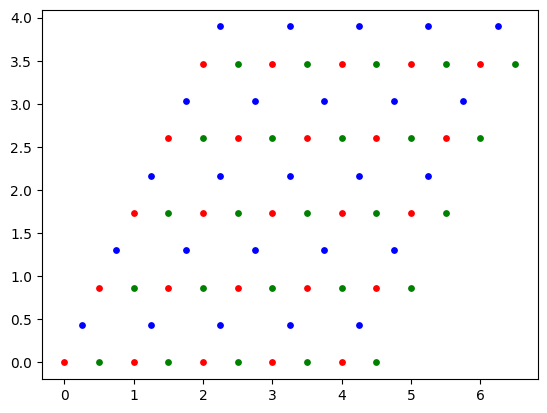

: 

In [ ]:

a=1
theta=2*np.pi/3
Nx=5
Ny=5
N=Nx*Ny
print('number of lattice points=',3*N)


a_1=a*np.array([1,0])
a_2=a*np.array([-1*np.cos(theta),np.sin(theta)])

unit_cell=np.array([[0,0],0.5*a_2,0.5*a_1])
x_l,y_l=np.meshgrid(range(Nx),range(Ny))
lattice=np.tensordot(np.ones((Nx,Ny)),unit_cell,axes=0)+np.tensordot(y_l,[a_1,a_1,a_1],axes=0)+np.tensordot(x_l,[a_2,a_2,a_2],axes=0)


dim=lattice.shape
config=2*np.random.rand(dim[0],dim[1],dim[2],3)-1*np.ones((dim[0],dim[1],dim[2],3))


Norm=np.power(LA.norm(config,axis=0),-1)
config=Norm*config



x_1,y_1,s_1=0,0,2

for i, color in enumerate(['black','black', 'black']):

    plt.scatter(lattice[:,:,i,0],lattice[:,:,i,1], c=color, label=' ',s=10)

plt.scatter(lattice[x_1,y_1,s_1,0],lattice[x_1,y_1,s_1,1], c='red', label=' ',s=15)

plt.show()

for i, color in enumerate(['black','black', 'black']):

    plt.scatter(lattice[:,:,i,0],lattice[:,:,i,1], c=color, label=' ',s=10)


plt.scatter(lattice[x_1,y_1,0,0],lattice[x_1,y_1,0,1], c='blue', label=' ',s=15)
plt.scatter(lattice[x_1,y_1,1,0],lattice[x_1,y_1,1,1], c='blue', label=' ',s=15)
plt.scatter(lattice[x_1,y_1,2,0],lattice[x_1,y_1,2,1], c='blue', label=' ',s=15)
plt.show()


P0=lattice[:,:,1,:]
P1=np.roll(lattice[:,:,2,:],(1,-1),(0,1))
P2=np.roll(lattice[:,:,0,:],-1,1)
Anti_lattice= np.concatenate((P0,P1,P2),axis=2).reshape((Nx,Ny,3,2),order='C')


print(Anti_lattice.shape)
#print(Anti_lattice)


lattice=np.roll(Anti_lattice,(Nx-1,1,1),(0,1,2))





x_1,y_1,s_1=0,0,2

for i, color in enumerate(['black','black', 'black']):

    plt.scatter(lattice[:,:,i,0],lattice[:,:,i,1], c=color, label=' ',s=10)

plt.scatter(lattice[x_1,y_1,s_1,0],lattice[x_1,y_1,s_1,1], c='red', label=' ',s=15)

plt.show()

for i, color in enumerate(['black','black', 'black']):

    plt.scatter(lattice[:,:,i,0],lattice[:,:,i,1], c=color, label=' ',s=10)


plt.scatter(lattice[x_1,y_1,0,0],lattice[x_1,y_1,0,1], c='blue', label=' ',s=15)
plt.scatter(lattice[x_1,y_1,1,0],lattice[x_1,y_1,1,1], c='blue', label=' ',s=15)
plt.scatter(lattice[x_1,y_1,2,0],lattice[x_1,y_1,2,1], c='blue', label=' ',s=15)
plt.show()


for i, color in enumerate(['red','blue', 'green']):
    plt.scatter(lattice[:,:,i,0],lattice[:,:,i,1], c=color, label=' ',s=15)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from numpy.random import rand, normal
import scipy
from scipy.spatial.transform import Rotation as R


def plot_3d_vecs(vs):
    if type(vs) == list:
        vs = np.array(vs)
        
    fig = plt.figure(figsize=(10,10))

    _plot_2d_arrows(vs, 1)
    _plot_2d_histogram(vs, 2, 'z')
    _plot_2d_histogram(vs, 3, 'x')
   
    #_plot_3d_points(vs, 3)
    
    plt.tight_layout()

    plt.show()
    
def _plot_2d_arrows(vs, plot_ix):
    # Plot arrows for the first 1000 or so, projected in 2d
    ax = plt.subplot(1, 3, plot_ix)
    ax.set_title('100 vecs plotted in 3D')
    
    ax.set_aspect('equal', adjustable='box')
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    [ax.arrow(0, 0, x, y, head_width=0.05, head_length=0.1) for (x,y,z) in vs[:]]
    
def _plot_2d_histogram(vs, plot_ix, axis='x'):
    # Histogram of angles, also projected in 2d
    ax = plt.subplot(1, 3, plot_ix, projection='polar')
    ax.set_title(f'Histogram of angles about {axis} axis')
    
    if axis == 'x':
        angles = [np.arctan2(z, y) for (x,y,z) in vs]
    if axis == 'y':
        angles = [np.arctan2(x, z) for (x,y,z) in vs]
    if axis == 'z':
        angles = [np.arctan2(y, x) for (x,y,z) in vs]

    ax.hist(angles, bins=100)

def _plot_3d_points(vs, plot_ix):
    # Plot the points on a sphere.
    ax = plt.subplot(1, 3, plot_ix, projection='3d')
    ax.set_title('300 pts shown on a sphere')

    # Plot a sphere
    phi, theta = np.mgrid[0.0:np.pi:100j, 0.0:2.0*np.pi:100j]
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)
    ax.plot_surface(
        x, y, z,  rstride=1, cstride=1, color='c', alpha=0.3, linewidth=0)

    # Plot data
    data = vs[:300]*1.05
    xx, yy, zz = np.hsplit(data, 3) 
    ax.scatter(xx, yy, zz, color="k", s=20)

    # Matplotlib actually sucks - removed set_axis equal for 3d plots... so have to make
    # spheres look roughly spherical by this bs now ;-;
    r = 1.3
    ax.set_xlim([-r,r])
    ax.set_ylim([-r,r])
    ax.set_zlim([-1,1])


vs = []
for i in range(10000):
    delta=10**-6
    q =normal(scale=[1,delta,delta,delta],size=(4))
    
    
    r = R.from_quat(q)
    v = r.apply(np.array([0,0,1]))  # Hence... Random vector?
    vs.append(v)

plot_3d_vecs(vs)